In [1]:
import hydra
import settings
import os
os.chdir(settings.current_file_dir)
import torch
import numpy as np

import data

import matplotlib.pyplot as plt
from pathlib import Path

from PIL import Image
import torch.nn.functional as F

import pandas as pd
import seaborn as sns

from core.detection.evaluation import compute_metrics
%matplotlib inline

In [2]:
in_dataset = "cifar100"
net = "densenet"
# ctm_scores = torch.load(f'outputs/ood_eval/{in_dataset}_{net}/CTMDetector/ctm_layer=0_ref=class_mean.pth')
# # mls_scores = torch.load(f'outputs/ood_eval/{in_dataset}_{net}/MLSDetector/mls.pth')
# ctm_weight_scores = torch.load(f'outputs/ood_eval/{in_dataset}_{net}/CTMDetector/ctm_layer=0_ref=last_weight.pth')
# ctm_weight_meanshift_scores = torch.load(f'outputs/ood_eval/{in_dataset}_{net}/CTMDetector/ctm_layer=0_ref=last_weight_shift=global_mean.pth')
# ctm_clsmean_meanshift_scores = torch.load(f'outputs/ood_eval/{in_dataset}_{net}/CTMDetector/ctm_layer=0_ref=class_mean_shift=global_mean.pth')

# ctm_weight_scores = {"id_scores": {in_dataset: ctm_scores["id_aux"][in_dataset]['last_weight']}, "ood_scores": ctm_scores["ood_aux"]}

# ctm_results = pd.read_csv(f'outputs/ood_eval/{in_dataset}_{net}/CTMDetector/ctm_layer=0_ref=class_mean.csv')
# ctm_weight_results = pd.read_csv(f'outputs/ood_eval/{in_dataset}_{net}/CTMDetector/ctm_layer=0_ref=last_weight.csv')
# ctm_weight_meanshift_results = pd.read_csv(f'outputs/ood_eval/{in_dataset}_{net}/CTMDetector/ctm_layer=0_ref=last_weight_shift=global_mean.csv')
# ctm_clsmean_meanshift_results = pd.read_csv(f'outputs/ood_eval/{in_dataset}_{net}/CTMDetector/ctm_layer=0_ref=class_mean_shift=global_mean.csv')

In [3]:
with hydra.initialize(version_base=None, config_path= str('../../..' / settings.hydra_cfg_path.relative_to(settings.root)) ):
    cfg = hydra.compose(config_name="ood_eval", return_hydra_config=True, 
                 overrides=[f"net={net}", f"in_dataset={in_dataset}"])

# Log config
DATA_ROOT = Path(os.environ['TORCH_DATASETS'])
print(DATA_ROOT)
if 'data_mean' in cfg.net: # set data mean and std
    data.NORM_PARAMS[cfg.in_dataset]["mean"] = cfg.net.data_mean
    data.NORM_PARAMS[cfg.in_dataset]["std"] = cfg.net.data_std
print(data.NORM_PARAMS[cfg.in_dataset])

# Load in-distribution data
id_data_dict = data.get_id_datasets_dict(DATA_ROOT, cfg.in_dataset, test_transform=lambda x: x)
NUM_CLASSES = id_data_dict['meta']['num_classes']
print(f'Using {data.ID2PRINTNAME[cfg.in_dataset]} as typical data')

# Load ood data
ood_datasets_dict = data.get_ood_datasets_dict(DATA_ROOT, cfg.in_dataset, id_transform=lambda x: x)

/home/cyanos/Workspace/pytorch_datasets
{'mean': [0.4914, 0.4822, 0.4465], 'std': [0.2023, 0.1994, 0.201]}
Using CIFAR-100 as typical data


In [4]:
colors = sns.color_palette("Set2", 3)
colors[0], colors[2] = colors[2], colors[0]

In [5]:
scores = torch.load(f"outputs/ood_eval/{in_dataset}_densenet/CTMDetector/ctm_layer=0.pth")
msp_scores = torch.load(f"outputs/ood_eval/{in_dataset}_densenet/MSPDetector/msp_T=0.3_use_xent=False.pth")

In [6]:
ctm_mean_scores = {}
ctm_mean_scores['ood_scores'] = {o: [v[0]['class_mean']] for o, v in scores['ood_scores'].items()}
ctm_mean_scores['id_scores'] = {in_dataset: scores['id_scores'][in_dataset]['class_mean']}

ctm_weight_scores = {}
ctm_weight_scores['ood_scores'] = {o: [v[0]['last_weight']] for o, v in scores['ood_scores'].items()}
ctm_weight_scores['id_scores'] = {in_dataset: scores['id_scores'][in_dataset]['last_weight']}

ctm_weight_meanshift_scores = {}
ctm_weight_meanshift_scores['ood_scores'] = {o: [v[0]['shifted_last_weight']] for o, v in scores['ood_scores'].items()}
ctm_weight_meanshift_scores['id_scores'] = {in_dataset: scores['id_scores'][in_dataset]['shifted_last_weight']}

ctm_clsmean_meanshift_scores = {}
ctm_clsmean_meanshift_scores['ood_scores'] = {o: [v[0]['shifted_class_mean']] for o, v in scores['ood_scores'].items()}
ctm_clsmean_meanshift_scores['id_scores'] = {in_dataset: scores['id_scores'][in_dataset]['shifted_class_mean']}

## The problem of MLS 

In [7]:
ood_names = list(scores['ood_aux'].keys())
print(ood_names)
print(scores['ood_aux'][ood_names[0]][0].keys())

['SVHN', 'LSUN-C', 'LSUN-R', 'iSUN', 'Textures', 'CIFAR-10']
dict_keys(['preds', 'feat_norm', 'shifted_feat_norm', 'probs'])


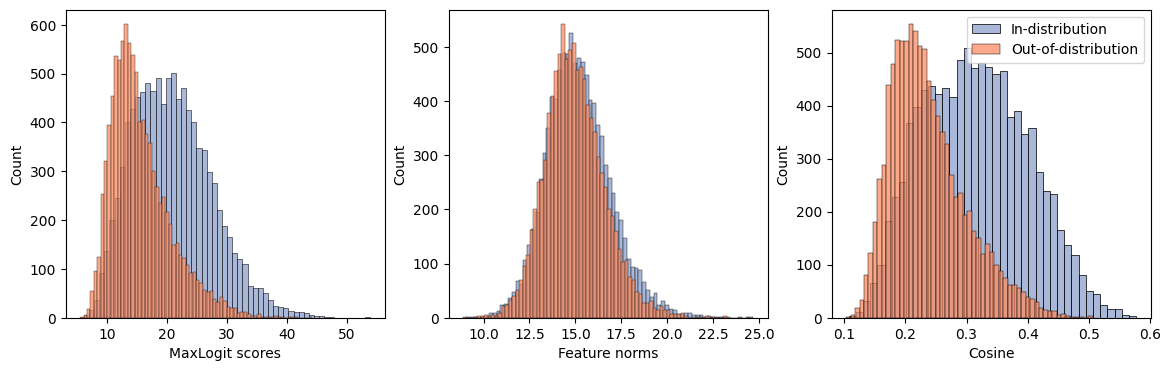

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
ood_set = "CIFAR-10"
sns.histplot(msp_scores['id_scores'][in_dataset]['mls'], ax=axes[0], label='In-distribution', color=colors[0], fill=True)
sns.histplot(msp_scores['ood_scores'][ood_set][0]['mls'], ax=axes[0], label='Out-of-distribution', color=colors[1], fill=True)
axes[0].set_xlabel("MaxLogit scores")

sns.histplot(scores['id_aux'][in_dataset]['feat_norm'], ax=axes[1], label='In-distribution', color=colors[0], fill=True)
sns.histplot(scores['ood_aux'][ood_set][0]['feat_norm'], ax=axes[1], label='Out-of-distribution', color=colors[1], fill=True)
axes[1].set_xlabel("Feature norms")

sns.histplot(ctm_weight_scores['id_scores'][in_dataset], ax=axes[2], label='In-distribution', color=colors[0], fill=True)
sns.histplot(ctm_weight_scores['ood_scores'][ood_set][0], ax=axes[2], label='Out-of-distribution', color=colors[1], fill=True)
axes[2].set_xlabel("Cosine")

plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


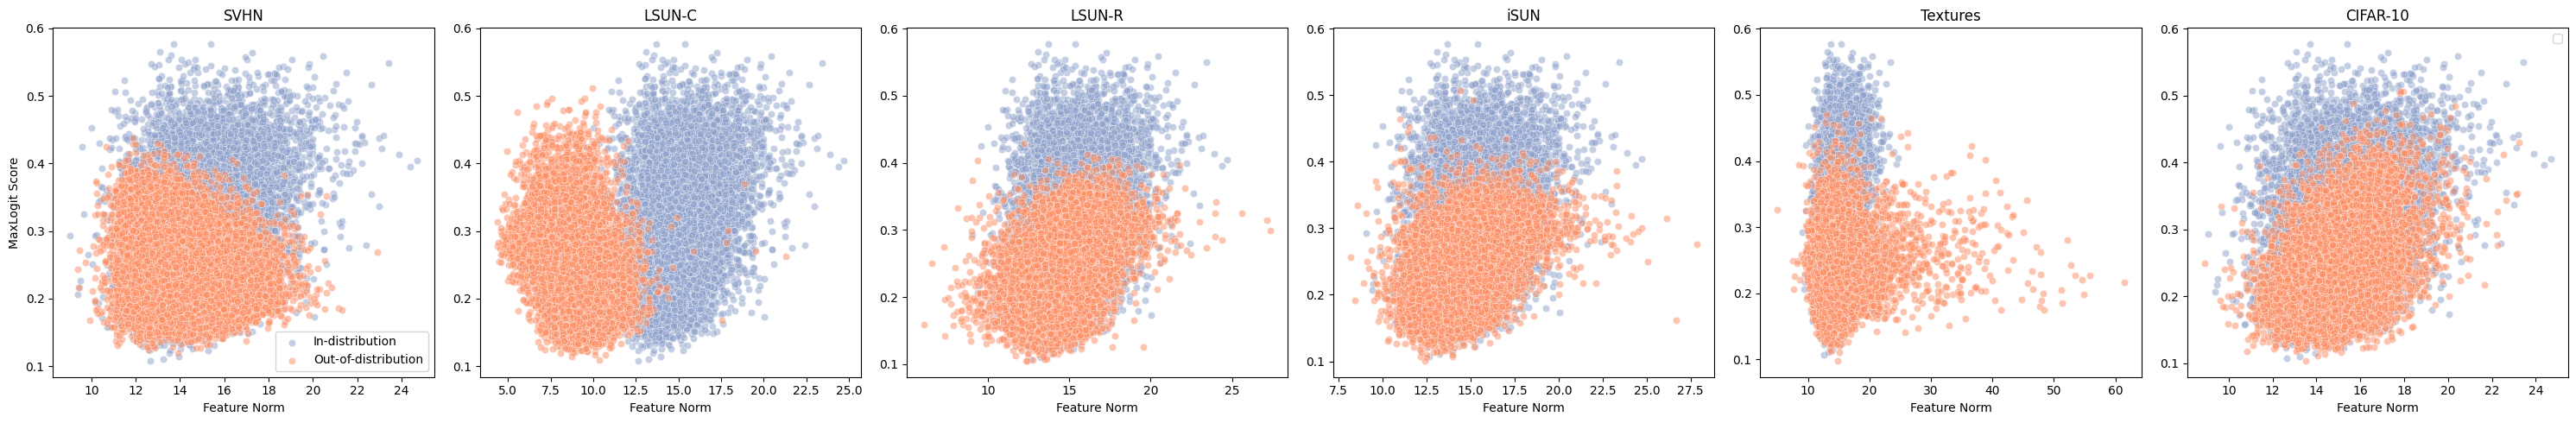

In [9]:
fig, axes = plt.subplots(1, len(ood_names), figsize=(5*len(ood_names), 5))
for i, ood_name in enumerate(ood_names):
    # sns.scatterplot(x=scores['id_aux']['cifar100']['feat_norm'], 
    #                 y=ctm_weight_scores['id_scores'][in_dataset], 
    #                 ax=axes[i], 
    #                 label='In-distribution' if i == 0 else None, 
    #                 color=colors[0], alpha=0.5)

    # sns.scatterplot(x=scores['ood_aux'][ood_name][0]['feat_norm'], 
    #                 y=ctm_weight_scores['ood_scores'][ood_name][0], 
    #                 ax=axes[i], 
    #                 label='Out-of-distribution' if i == 0 else None, 
    #                 color=colors[1], alpha=0.5)

    x_id = scores['id_aux']['cifar100']['feat_norm']
    y_id = ctm_weight_scores['id_scores'][in_dataset]
    # y_id = msp_scores['id_scores'][in_dataset]['mls']
    
    x_ood = scores['ood_aux'][ood_name][0]['feat_norm']
    y_ood = ctm_weight_scores['ood_scores'][ood_name][0]
    # y_ood = msp_scores['ood_scores'][ood_name][0]['mls']

    sns.scatterplot(x=x_id, y=y_id, 
                    ax=axes[i], 
                    label='In-distribution' if i == 0 else None, 
                    color=colors[0], alpha=0.5)
    sns.scatterplot(x=x_ood, y=y_ood, 
                    ax=axes[i], 
                    label='Out-of-distribution' if i == 0 else None, 
                    color=colors[1], alpha=0.5)
    
    axes[i].set_title(ood_name)
    axes[i].set_xlabel('Feature Norm')
    if i == 0:
        # axes[i].set_ylabel('Cosine (z, w)')
        axes[i].set_ylabel('MaxLogit Score')

    # sns.scatterplot(x=scores['id_aux']['cifar100']['feat_norm'], 
    #                 y=scores['id_aux']['cifar100']['preds'], 
    #                 ax=plt.gca(), label='In-distribution', color=colors[0], alpha=0.5)

    # sns.scatterplot(x=scores['ood_aux'][ood_set][0]['feat_norm'], 
    #                 y=scores['ood_aux']["SVHN"][0]['preds'], 
    #                 ax=plt.gca(), label='In-distribution', color=colors[1], alpha=0.5)

plt.tight_layout()
plt.legend()
plt.show()

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [46]:
all_metrics = []
for i, ood_name in enumerate(ood_names):
    x1_id = scores['id_aux'][in_dataset]['feat_norm']
    x2_id = ctm_weight_scores['id_scores'][in_dataset]
    x3_id = msp_scores['id_scores'][in_dataset]['mls'] / (x1_id * x2_id)
    # x4_id = ctm_weight_meanshift_scores['id_scores'][in_dataset]
    x4_id = scores['id_aux'][in_dataset]['shifted_feat_norm']
    # x3_id = x1_id * x2_id
    
    x1_ood = scores['ood_aux'][ood_name][0]['feat_norm']
    x2_ood = ctm_weight_scores['ood_scores'][ood_name][0]
    x3_ood = msp_scores['ood_scores'][ood_name][0]['mls'] / (x1_ood * x2_ood)
    # x4_ood = ctm_weight_meanshift_scores['ood_scores'][ood_name][0]
    x4_ood = scores['ood_aux'][ood_name][0]['shifted_feat_norm']
    # x3_ood = x1_ood * x2_ood


    # X_id = np.stack([x1_id, x2_id, x3_id], axis=1)
    # X_ood = np.stack([x1_ood, x2_ood, x3_ood], axis=1)
    # X_id = np.stack([x1_id, x2_id], axis=1)
    # X_ood = np.stack([x1_ood, x2_ood], axis=1)
    # X_id = np.stack([x2_id, x3_id], axis=1)
    # X_ood = np.stack([x2_ood, x3_ood], axis=1)
    # X_id = np.stack([x1_id, x3_id], axis=1)
    # X_ood = np.stack([x1_ood, x3_ood], axis=1)
    # X_id = np.stack([x1_id, x2_id], axis=1)
    # X_ood = np.stack([x1_ood, x2_ood], axis=1)
    X_id = np.stack([x1_id, x2_id, x3_id, x4_id], axis=1)
    X_ood = np.stack([x1_ood, x2_ood, x3_ood, x4_ood], axis=1)

    X = np.concatenate([X_id, X_ood], axis=0)
    y = np.concatenate([np.ones(len(X_id)), np.zeros(len(X_ood))], axis=0)
    
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    # print(scaler.mean_, scaler.scale_)

    clf = LogisticRegression(random_state=0).fit(X, y)
    # y_hat = clf.predict_proba(X)[:, 1]
    y_hat = (X @ clf.coef_.T + clf.intercept_).squeeze()
    # acc = np.mean(y_hat == y)
    metrics = [m*100 for m in compute_metrics(y_hat[:len(X_id)], y_hat[len(X_id):])]
    metrics = [f"{m:.2f}" for m in metrics]
    metrics = " & ".join([metrics[2], metrics[0]])
    all_metrics.append(metrics)
    print(ood_name, clf.coef_, clf.intercept_, metrics)
    # print(y_hat)
print(" & ".join(all_metrics))

SVHN [[ 3.89616302  3.03712698  0.45605854 -4.54759718]] [-2.30292153] 13.66 & 97.30
LSUN-C [[10.39951502  2.01919967  0.11230075 -2.58785382]] [-0.55209188] 0.30 & 99.86
LSUN-R [[ 3.18159314  3.22425708  1.60003597 -4.09070501]] [0.16319455] 20.74 & 96.27
iSUN [[ 3.39930675  3.148093    1.55110042 -4.5011116 ]] [0.3602656] 18.12 & 96.79
Textures [[ 4.73179388  2.87215533  0.31096355 -7.36575526]] [0.83856124] 18.32 & 96.22
CIFAR-10 [[-0.55351436  1.27448099  0.28957284  0.33125142]] [0.05708106] 80.19 & 78.05
13.66 & 97.30 & 0.30 & 99.86 & 20.74 & 96.27 & 18.12 & 96.79 & 18.32 & 96.22 & 80.19 & 78.05


In [48]:
all_metrics = []
for i, ood_name in enumerate(ood_names):
    x1_id = scores['id_aux'][in_dataset]['feat_norm']
    x2_id = ctm_weight_scores['id_scores'][in_dataset]
    x3_id = msp_scores['id_scores'][in_dataset]['mls'] / (x1_id * x2_id)
    # x4_id = ctm_weight_meanshift_scores['id_scores'][in_dataset]
    x4_id = scores['id_aux'][in_dataset]['shifted_feat_norm']
    # x3_id = x1_id * x2_id
    
    x1_ood = scores['ood_aux'][ood_name][0]['feat_norm']
    x2_ood = ctm_weight_scores['ood_scores'][ood_name][0]
    x3_ood = msp_scores['ood_scores'][ood_name][0]['mls'] / (x1_ood * x2_ood)
    # x4_ood = ctm_weight_meanshift_scores['ood_scores'][ood_name][0]
    x4_ood = scores['ood_aux'][ood_name][0]['shifted_feat_norm']

    # id_scores =  4.02661541*(x1_id - 14.61050294) / 1.5795944  +  2.90556899 * (x2_id - 0.25705103)/0.06985888 - 4.65689144*(x4_id - 10.8441683) / 1.40794674  -2.24273709
    # ood_scores = 4.02661541*(x1_ood - 14.61050294) / 1.5795944  +  2.90556899 * (x2_ood - 0.25705103)/0.06985888 - 4.65689144*(x4_ood - 10.8441683) / 1.40794674  -2.24273709

    id_scores = x2_id
    ood_scores = x2_ood

    metrics = [m*100 for m in compute_metrics(id_scores, ood_scores)]
    metrics = [f"{m:.2f}" for m in metrics]
    metrics = " & ".join([metrics[2], metrics[0]])
    all_metrics.append(metrics)
print(" & ".join(all_metrics))

88.28 & 78.76 & 86.97 & 71.64 & 79.36 & 77.02 & 83.55 & 75.76 & 84.61 & 77.54 & 80.67 & 76.74


In [ ]:
SVHN [[-2.77607925  4.29270702]] (0.827376413644745, 0.7541027313385216, 0.8125)
LSUN-C [[-4.25562456  5.47051492]] (0.8175056199999999, 0.8381389027911219, 0.7541)
LSUN-R [[-7.63043682  9.66678097]] (0.8897614, 0.9146037679289724, 0.6541)
iSUN [[-7.29981589  9.23396196]] (0.8869704201680673, 0.9179679172598392, 0.6480672268907564)
Textures [[-1.20426259  2.54024853]] (0.7960692553191488, 0.88243699550244, 0.8182624113475178)
CIFAR-10 [[-0.16317235  1.34539592]] (0.773089885, 0.7845276471083322, 0.797)

In [24]:
# scores = torch.load('outputs/ood_eval/debug/CTMDetector/ctm_layer=0.pth')
scores = torch.load(f'outputs/ood_eval/{in_dataset}_{net}/CTMDetector/ctm_layer=0.pth')

In [23]:
ind = torch.argwhere(scores['ood_aux']['LSUN-R'][0]['preds'] == 0).squeeze()
scores['ood_scores']['LSUN-R'][0]['class_mean'][ind]

def plot_scorehist_by_class(scores, id_name, ood_name, version, class_id, bins=100):
    ood_ind = torch.argwhere(scores['ood_aux'][ood_name][0]['preds'] == class_id).squeeze()
    id_ind = torch.argwhere(scores['id_aux'][id_name][version]['preds'] == class_id).squeeze()

    id_scores = scores['in_score_dict'][id_name][version][id_ind]
    ood_scores = scores['ood_scores'][ood_name][0][version][id_ind]
    fig, ax = plt.subplots()
    ax.hist(id_scores, bins=bins, density=True, alpha=0.5, label=f'{id_name} {class_name}')
    ax.hist(ood_scores, bins=bins, density=True, alpha=0.5, label=f'{ood_name} {class_name}')
    ax.legend(loc='upper right')
    ax.set_title(f'Class {class_id}')
    plt.show()



In [24]:
def plot_dist_scores(id_scores, ood_scores, ax, title):
    sns.histplot(id_scores, ax=ax, label='In-distribution', color=colors[0], fill=True)
    sns.histplot(ood_scores, ax=ax, label='Out-of-distribution', color=colors[1], fill=True)
    # sns.histplot(np.arccos(id_scores)*180/np.pi, ax=ax, label='In-distribution', color=colors[0], fill=True)
    # sns.histplot(np.arccos(ood_scores)*180/np.pi, ax=ax, label='Out-of-distribution', color=colors[1], fill=True)
    ax.set_title(title)
    ax.set_xlabel('Score')
    ax.set_ylabel('Density')
    ax.legend()


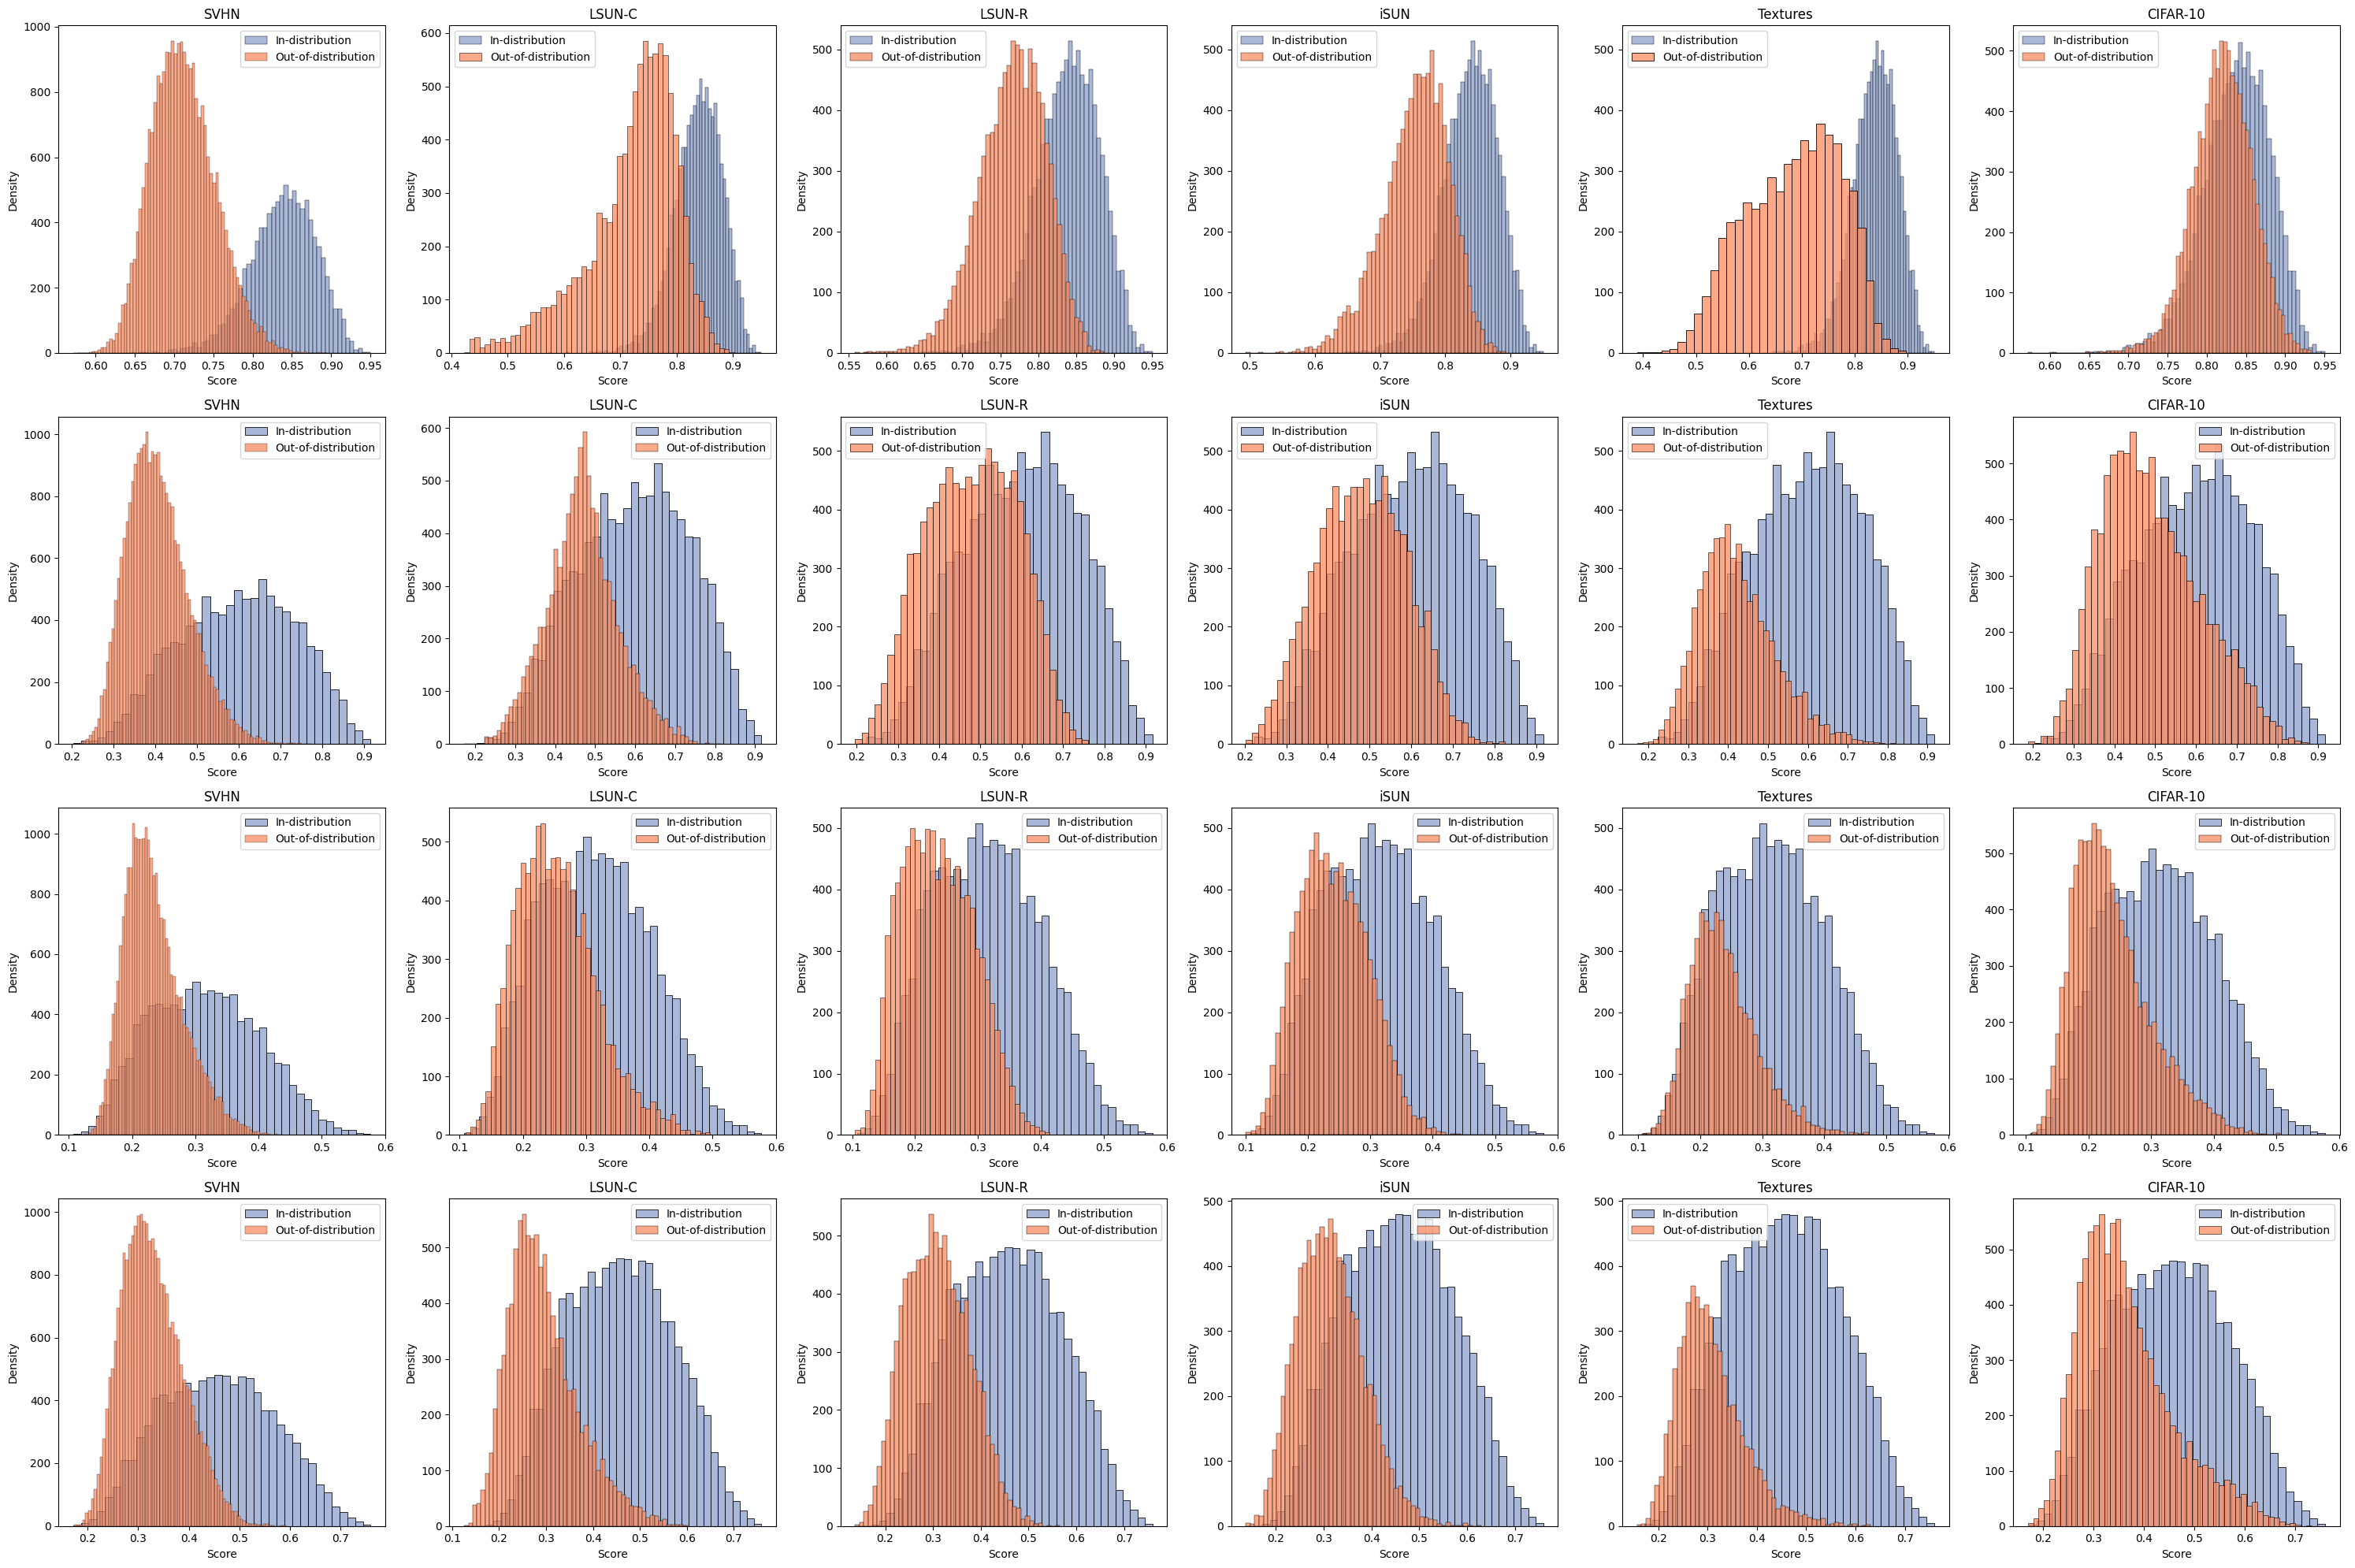

In [25]:
fig, axes = plt.subplots(4, len(ctm_mean_scores['ood_scores']), figsize=(5*len(ctm_mean_scores['ood_scores']), 20))
for i, ood_name in enumerate(ctm_mean_scores['ood_scores'].keys()):
    # plot_dist_scores(ctm_mean_scores['id_scores'][in_dataset], ctm_mean_scores['ood_scores'][ood_name][0], axes[0][i], ood_name)
    # plot_dist_scores(ctm_clsmean_meanshift_scores['id_scores'][in_dataset], ctm_clsmean_meanshift_scores['ood_scores'][ood_name][0], axes[1][i], ood_name)
    
    plot_dist_scores(ctm_weight_scores['id_scores'][in_dataset], ctm_weight_scores['ood_scores'][ood_name][0], axes[2][i], ood_name)
    plot_dist_scores(ctm_weight_meanshift_scores['id_scores'][in_dataset], ctm_weight_meanshift_scores['ood_scores'][ood_name][0], axes[3][i], ood_name)
plt.tight_layout()

In [56]:
def concat_results(results):
    processed_df = []
    for df in results:
        tmp = df[['ood_data', 'fpr']].T
        tmp.columns = tmp.iloc[0]
        tmp = tmp.iloc[1:]
        tmp = tmp.reset_index(drop=True)
        tmp['Average'] = tmp.mean(axis=1)
        tmp['detector'] = df['detector'].iloc[0]
        processed_df.append(tmp)
    return pd.concat(processed_df, axis=0)
concated_results = concat_results([ctm_results, ctm_clsmean_meanshift_results, ctm_weight_results, ctm_weight_meanshift_results])
concated_results

ood_data       SVHN LSUN-C LSUN-R       iSUN   Textures CIFAR-100    Average  \
0          5.201291  10.92   9.48  10.240896  17.641844     58.18  18.610672   
0          8.493393   3.59   7.56   8.190476  22.553191     48.36  16.457843   
0         22.103565  40.71   19.3  21.109244  51.932624     49.45  34.100905   
0          4.817148   3.34   8.76   9.389356  23.386525     48.35  16.340505   

ood_data                                       detector  
0                            ctm_layer=0_ref=class_mean  
0          ctm_layer=0_ref=class_mean_shift=global_mean  
0                           ctm_layer=0_ref=last_weight  
0         ctm_layer=0_ref=last_weight_shift=global_mean

In [77]:
classes = id_data_dict['ds']['test'].classes
labels = id_data_dict['ds']['test'].targets
def plot_image_by_score(scores, dataset, preds=None, labels=None, title=None, classes=None, probs=None):
    indexes = np.argsort(-scores)
    fig, axes = plt.subplots(2, 20, figsize=(20, 6))
    for i, index in enumerate(indexes[:20]):
        ood_data = dataset[index]
        image = ood_data[0]
        axes[0,i].imshow(image)
        axes[0,i].set_title(f'#{i+1}')
        axes[0,i].axis('off')
        axes[0,i].text(0, 0, f'{scores[index]:.2f}', color='red')
        if preds is not None:
            axes[0,i].text(0, 10, f'{classes[preds[index].item()]}', color='black')
        if labels is not None:
            axes[0,i].text(0, 20, f'{classes[labels[index]]}', color='black')
        if probs is not None:
            axes[0,i].text(0, 30, f'{probs[index][preds[index].item()].item():.2f}', color='black')
        # axes[0,i].text(0, 20, f'{index}', color='red')
    # plot top confident images
    for i, index in enumerate(indexes[-20:]):
        ood_data = dataset[index]
        image = ood_data[0]
        axes[1,i].imshow(image)
        axes[1,i].set_title(f'#{i+1}')
        axes[1,i].axis('off')
        axes[1,i].text(0, 0, f'{scores[index]:.2f}', color='red')
        if preds is not None:
            axes[1,i].text(0, 10, f'{classes[preds[index].item()]}', color='black')
        if labels is not None:
            axes[1,i].text(0, 20, f'{classes[labels[index]]}', color='black')
        if probs is not None:
            axes[1,i].text(0, 30, f'{probs[index][preds[index].item()].item():.2f}', color='black')
        # axes[1,i].text(0, 10, f'{index}', color='red')
    plt.tight_layout()

In [82]:
scores['id_aux'][in_dataset]['probs'].shape

torch.Size([10000, 100])

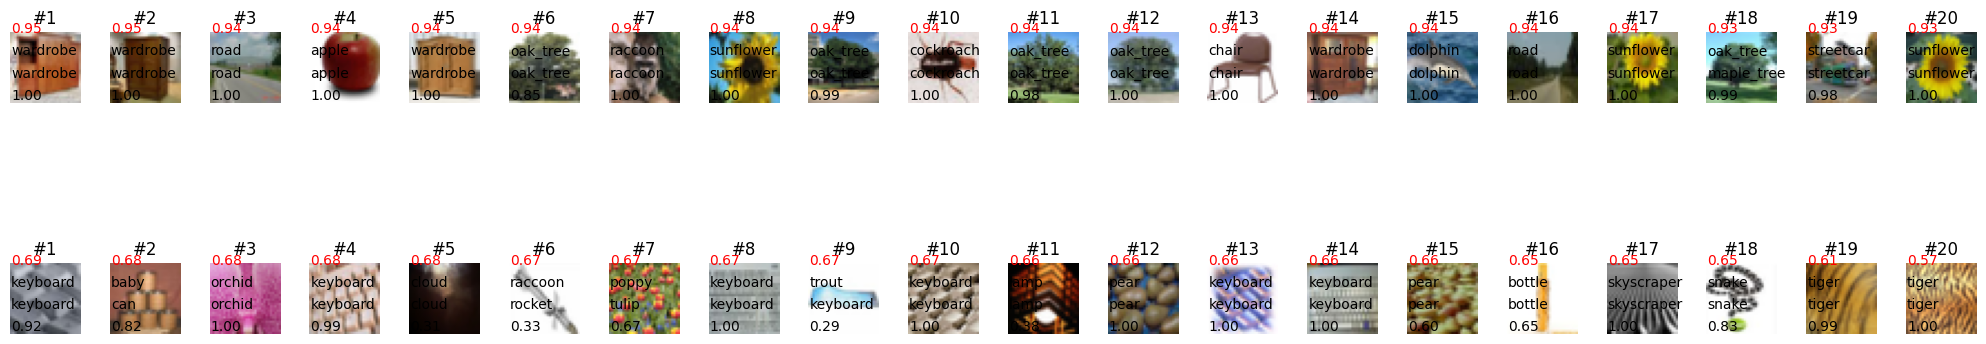

In [83]:
plot_image_by_score(ctm_mean_scores['id_scores'][in_dataset], id_data_dict['ds']['test'], 
                    preds=scores['id_aux'][in_dataset]['preds'], classes=classes, labels=labels,
                    probs=scores['id_aux'][in_dataset]['probs'],)

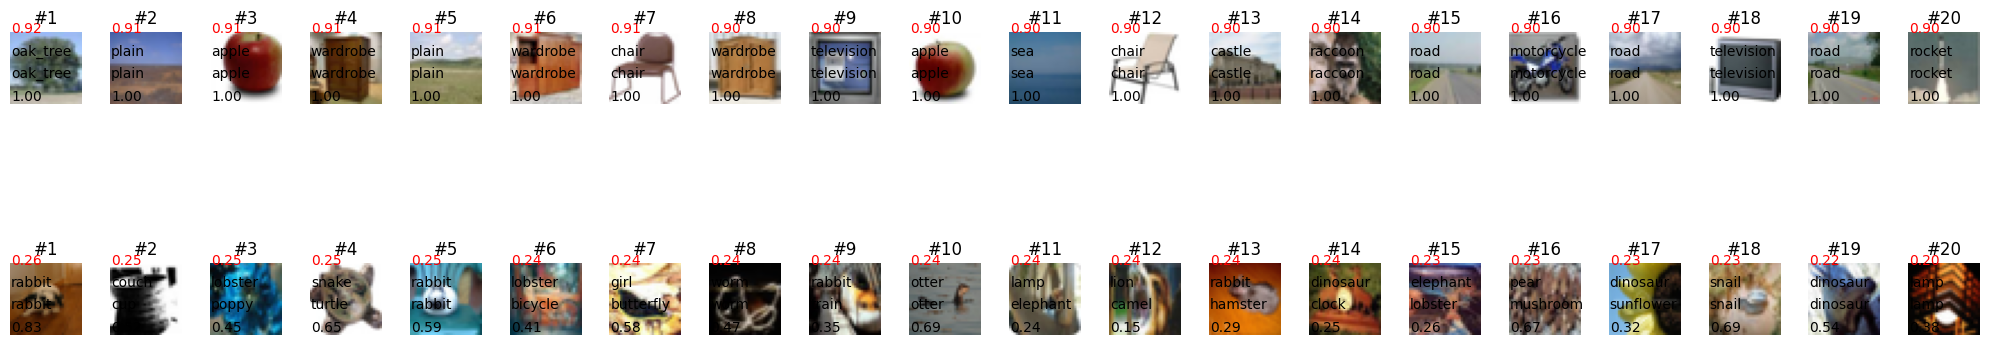

In [85]:
plot_image_by_score(ctm_clsmean_meanshift_scores['id_scores'][in_dataset], 
                    id_data_dict['ds']['test'], 
                    preds=scores['id_aux'][in_dataset]['preds'],
                    probs=scores['id_aux'][in_dataset]['probs'], 
                    classes=classes, labels=labels)

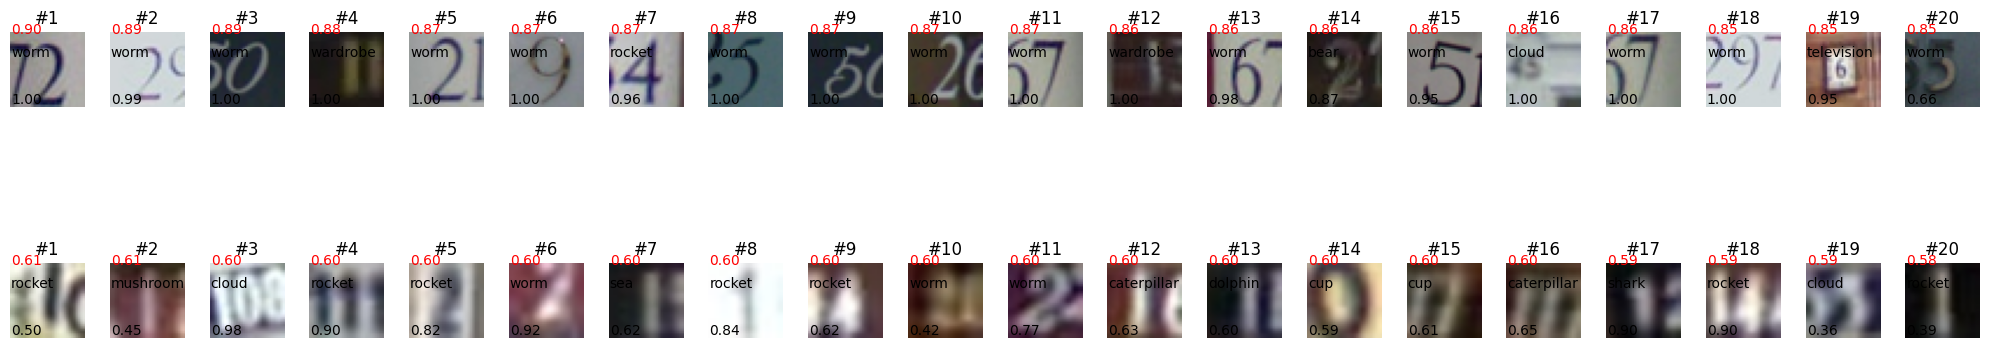

In [87]:
ood_name = 'SVHN'
# ood_name = 'Textures'
plot_image_by_score(ctm_mean_scores['ood_scores'][ood_name][0], 
                    ood_datasets_dict['ds']['far'][ood_name], 
                    preds=scores['ood_aux'][ood_name][0]['preds'], 
                    probs=scores['ood_aux'][ood_name][0]['probs'], 
                    classes=classes)

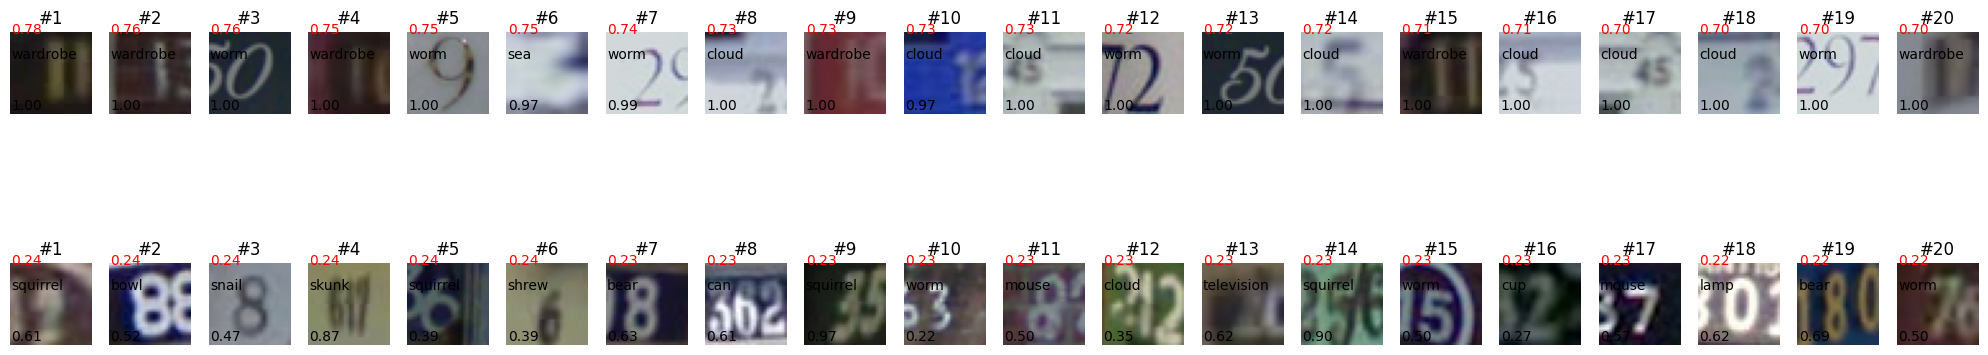

In [88]:
plot_image_by_score(ctm_clsmean_meanshift_scores['ood_scores'][ood_name][0], 
                    ood_datasets_dict['ds']['far'][ood_name], 
                    preds=scores['ood_aux'][ood_name][0]['preds'], 
                    probs=scores['ood_aux'][ood_name][0]['probs'], 
                    classes=classes)

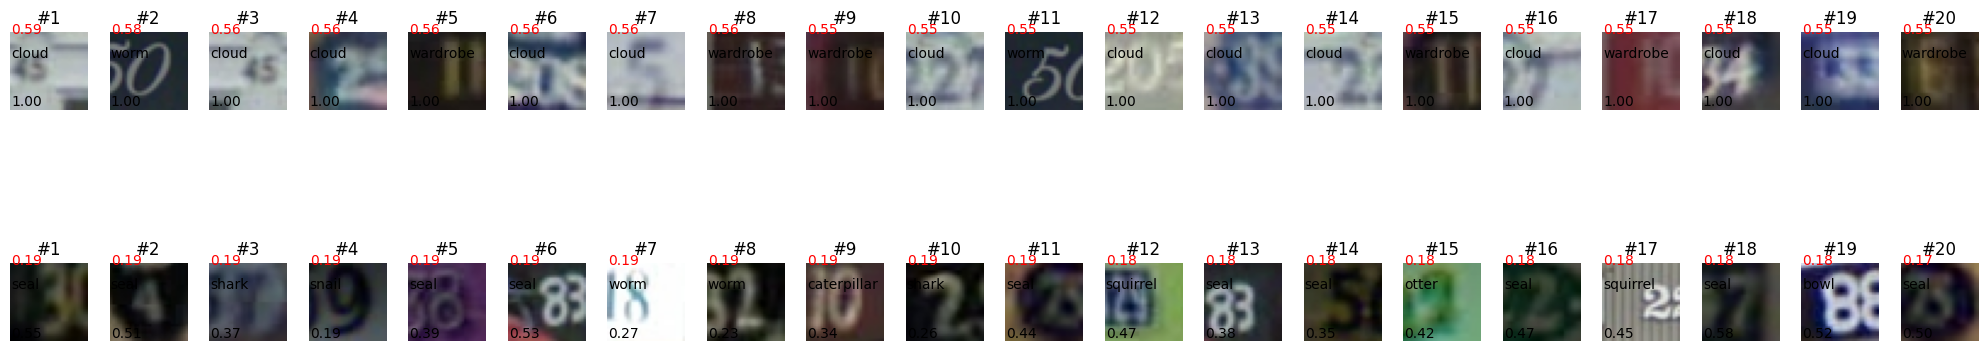

In [89]:
plot_image_by_score(ctm_weight_meanshift_scores['ood_scores'][ood_name][0], 
                    ood_datasets_dict['ds']['far'][ood_name], 
                    preds=scores['ood_aux'][ood_name][0]['preds'], 
                    probs=scores['ood_aux'][ood_name][0]['probs'], 
                    classes=classes)

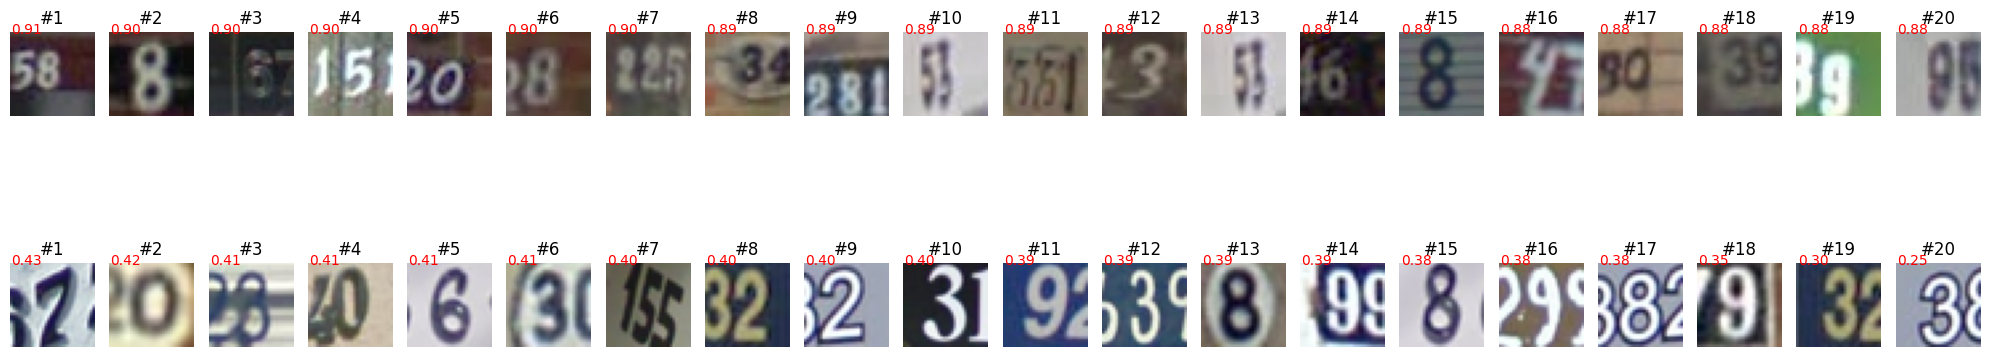

In [22]:
plot_image_by_score(ctm_weight_meanshift_scores['ood_scores'][ood_name][0], ood_datasets_dict['ds']['far'][ood_name])

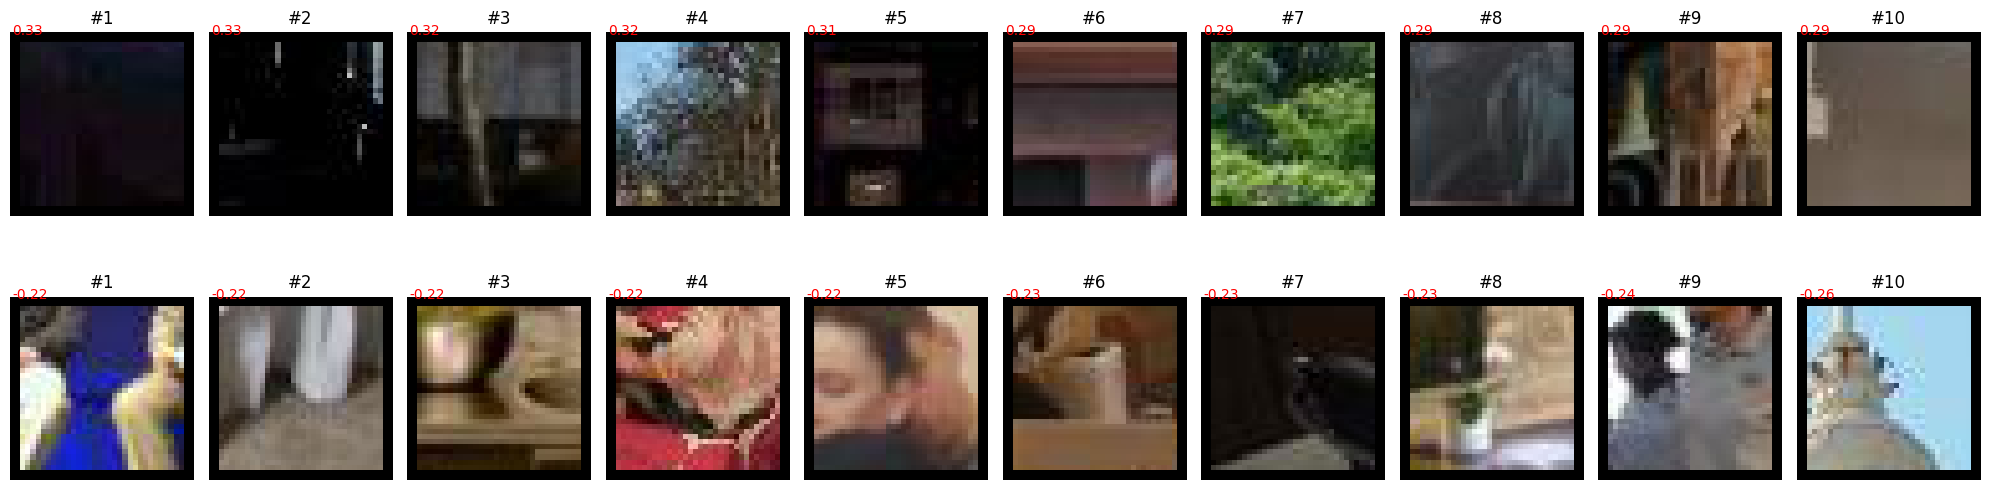

In [25]:
plot_image_by_score(ctm_weight_meanshift_scores['ood_scores'][ood_name][0], ood_datasets_dict['ds']['far'][ood_name])


In [25]:
#    id_data   ood_data  is_near detector  num_runs      auroc       aupr        fpr  auroc_std  aupr_std  fpr_std
# 0  cifar10       SVHN    False      mls         1  91.108018  79.246543  35.517824        0.0       0.0      0.0
# 1  cifar10     LSUN-C    False      mls         1  98.959046  99.061159   4.830000        0.0       0.0      0.0
# 2  cifar10     LSUN-R    False      mls         1  94.017066  94.098267  28.790000        0.0       0.0      0.0
# 3  cifar10       iSUN    False      mls         1  92.456306  93.199597  34.812325        0.0       0.0      0.0
# 4  cifar10   Textures    False      mls         1  85.489912  88.517767  52.056738        0.0       0.0      0.0
# 5  cifar10  CIFAR-100     True      mls         1  87.121675  85.845897  50.610000        0.0       0.0      0.0
# [2023-07-19 15:16:12,559][core.detection.pipelines.standard][INFO] - Mean Far-OOD Test Results
# auroc    92.406070
# aupr     90.824667
# fpr      31.201377
# dtype: float64
# [2023-07-19 15:16:12,560][core.detection.pipelines.standard][INFO] - Mean Near-OOD Test Results
# auroc    87.121675
# aupr     85.845897
# fpr      50.610000
# dtype: float64

#    id_data   ood_data  is_near     detector  num_runs      auroc       aupr        fpr  auroc_std  aupr_std  fpr_std
# 0  cifar10       SVHN    False  ctm_layer=0         1  95.635286  91.906687  27.178089        0.0       0.0      0.0
# 1  cifar10     LSUN-C    False  ctm_layer=0         1  94.040917  94.856272  36.420000        0.0       0.0      0.0
# 2  cifar10     LSUN-R    False  ctm_layer=0         1  93.069025  93.139527  35.870000        0.0       0.0      0.0
# 3  cifar10       iSUN    False  ctm_layer=0         1  91.120571  91.673898  41.075630        0.0       0.0      0.0
# 4  cifar10   Textures    False  ctm_layer=0         1  92.012842  95.270644  42.163121        0.0       0.0      0.0
# 5  cifar10  CIFAR-100     True  ctm_layer=0         1  88.392000  88.399661  55.340000        0.0       0.0      0.0
# [2023-07-19 14:39:15,403][core.detection.pipelines.standard][INFO] - Mean Far-OOD Test Results
# auroc    93.175728
# aupr     93.369406
# fpr      36.541368
# dtype: float64
# [2023-07-19 14:39:15,404][core.detection.pipelines.standard][INFO] - Mean Near-OOD Test Results
# auroc    88.392000
# aupr     88.399661
# fpr      55.340000
# dtype: float64
